# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
p = np.array([0.8, 0.2])
res = - np.sum(p * np.log(p))
print(round(res, 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
H_R_m = 0.2 * 0.8 + 0.8 * 0.2
H_R_l = 8/8 * (1 - 8/8) + 0/8 * (1 - 0/8) # = 0, можно не учитывать
H_R_r = 2/2 * (1 - 2/2) + 0/2 * (1 - 0/2) # = 0, можно не учитывать

round(H_R_m, 2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
r = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
np.average(r)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    def H(R):
        p = np.bincount(R) / len(R)
        return np.sum(p * (1 - p))

    def Q_classification(R_l, R_r):
        l1 = len(R_l) / len(target_vector)
        l2 = len(R_r) / len(target_vector)
        return H(target_vector) - l1 * H(R_l) - l2 * H(R_r)

    def Q_regression(R_l, R_r):
        l1 = len(R_l) / len(target_vector)
        l2 = len(R_r) / len(target_vector)
        return np.var(target_vector) - l1 * np.var(R_l) - l2 * np.var(R_r)

    def Rl_and_Rr_cat(t):
        R_l = target_vector[feature_vector == t]
        R_r = target_vector[feature_vector != t]
        return R_l, R_r

    def Rl_and_Rr_real(t):
        R_l = target_vector[feature_vector > t]
        R_r = target_vector[feature_vector <= t]
        return R_l, R_r

    thresholds = []
    sorted_feature_vector = np.array(sorted(np.unique(feature_vector)))
    ginis =[]

    if task == 'regression':
        if len(sorted_feature_vector) < 2:
            return sorted_feature_vector, np.array([0]), sorted_feature_vector[0], np.nan
        if feature_type == 'real':
            thresholds = (sorted_feature_vector[1:] +
                          sorted_feature_vector[:-1]) / 2
            for t in thresholds:
                R_l, R_r = Rl_and_Rr_real(t)
                ginis.append(Q_regression(R_l, R_r))

        if feature_type == 'categorical':
            thresholds = sorted_feature_vector
            for t in thresholds:
                R_l, R_r = Rl_and_Rr_cat(t)
                ginis.append(Q_regression(R_l, R_r))


    if task == 'classification':
        if len(sorted_feature_vector) < 2:
            return sorted_feature_vector, np.array([]), sorted_feature_vector[0], np.nan
        if feature_type == 'real':
            thresholds = (sorted_feature_vector[1:]
                          + sorted_feature_vector[:-1]) / 2
            for t in thresholds:
                R_l, R_r = Rl_and_Rr_real(t)
                ginis.append(Q_classification(R_l, R_r))

        if feature_type == 'categorical':
            for t in thresholds:
                R_l, R_r = Rl_and_Rr_cat(t)
                ginis.append(Q_classification(R_l, R_r))


    ginis = np.array(ginis)
    if len(ginis) == 0:
        return sorted_feature_vector, np.array([]), sorted_feature_vector[0], np.nan
    threshold_best = thresholds[ginis.argmax()]
    gini_best = ginis[ginis.argmax()]

    return thresholds, ginis, threshold_best, gini_best


Эту функцию можно протестировать на датасете `California`.

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

HTTPError: HTTP Error 403: Forbidden

In [69]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [70]:
thresholds, ginis, threshold_best, gini_best = find_best_split(
    X['MedInc'], y, task='regression', feature_type='real')

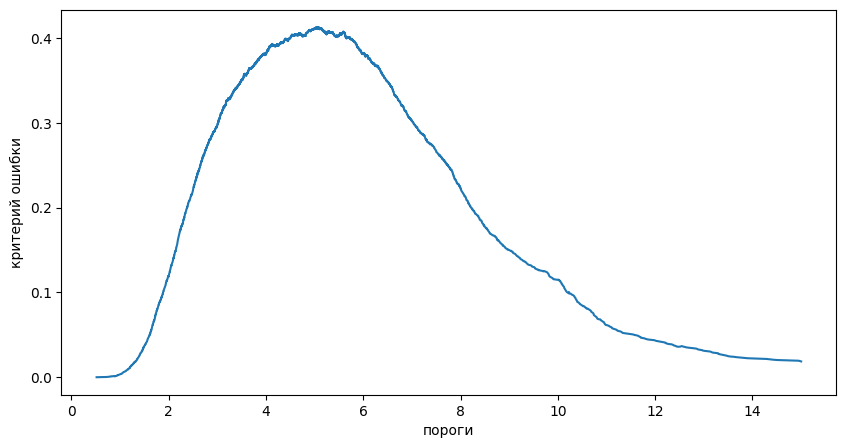

In [71]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, ginis)
plt.xlabel('пороги')
plt.ylabel('критерий ошибки')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [18]:
threshold_best

5.03515

Наилучший предикат находится в максимуме критерия ошибки, в данном случае это значени 5,03515.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [10]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y.iloc[0]):
            node["type"] = "terminal"
            node["class"] = sub_y.iloc[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X.iloc[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X.iloc[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (feature_vector > threshold)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        else:
            feature = node["feature_split"]
            if self._feature_types[feature] == "real":
                if x[feature] > node["thresholds"]:
                    _predict_node(x, node["left_child"])
                else:
                    _predict_node(x, node["right_child"])
            else:
                if x[feature] == node["category_split"]:
                    _predict_node(x, node["left_child"])
                else:
                    _predict_node(x, node["right_child"])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [74]:
df = pd.read_csv("students.csv", index_col=[0])
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [75]:
X = df.drop('UNS', axis=1)
y = df['UNS']

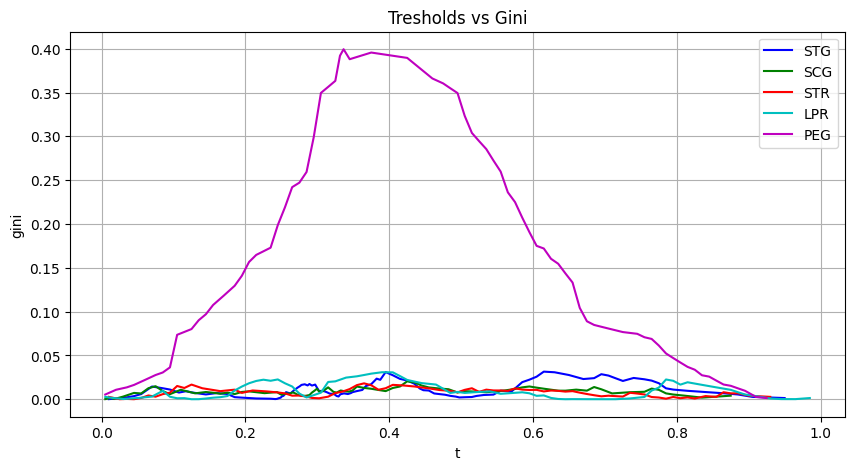

In [76]:
plt.figure(figsize=(10,5))
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(len(X.columns)):
    t, g, _, _ = find_best_split(X[X.columns[i]], y,
                          task='classification',
                          feature_type='real')
    plt.plot(t, g, colors[i])

plt.xlabel('t')
plt.ylabel('gini')
plt.legend(X.columns)
plt.title('Tresholds vs Gini')
plt.grid(True)
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Сразу видно, что проводить деление нужно по PEG, так как у него четко выроженный максимум и иделаьная форма графика, у остальных это какие-то прямые линии, по которым найти максимум довольно сложно и деление выборки почти невозможно, потому что нет никакой однозначности.
ТО есть для хороших признаков прямая должна быть похожа на параболу с ветвями вниз

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [16]:
df = pd.read_csv('agaricus-lepiota.data')
le = LabelEncoder()
for x in df.columns:
    df[x] = le.fit_transform(df[x])
X = df.drop('p', axis=1)
y = df['p']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=13)

In [17]:
feature_types = ['categorical'] * 22
dt = DecisionTree(feature_types=feature_types, task='classification')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

RecursionError: maximum recursion depth exceeded while calling a Python object

Ошибка в уже написанной ранее fit. Там были еще ошибки, например не было iloc, из-за чего тоже возникала ошибка, так как не получалось обратиться к элементам. Это я смогла исправить, а тут уже не знаю, что сделать

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [28]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [19]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

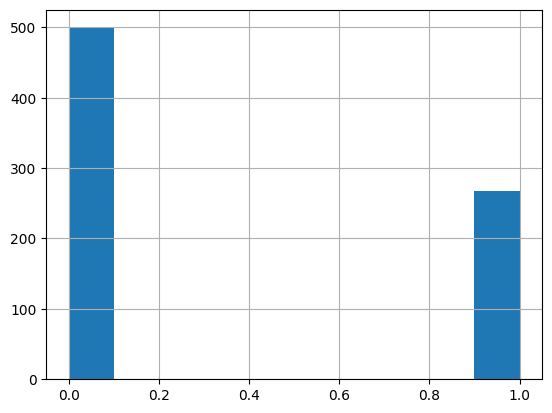

In [20]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [79]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=13)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=13)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [51]:
max_depth = [1, 5, 10, None]
min_samples_leaf = [15, 5, 1]
for d in max_depth:
    for l in min_samples_leaf:
        base_tree = DecisionTreeClassifier(max_depth=d,
                                           min_samples_leaf=l,
                                           random_state=13)
        base_tree.fit(X_train_train, y_train_train)
        y_pred = base_tree.predict(X_train_val)
        print(f'f1: {f1_score(y_train_val, y_pred)} with d = {d} and l = {l}')

f1: 0.559322033898305 with d = 1 and l = 15
f1: 0.559322033898305 with d = 1 and l = 5
f1: 0.559322033898305 with d = 1 and l = 1
f1: 0.5952380952380952 with d = 5 and l = 15
f1: 0.6526315789473683 with d = 5 and l = 5
f1: 0.6597938144329897 with d = 5 and l = 1
f1: 0.5842696629213483 with d = 10 and l = 15
f1: 0.5739130434782609 with d = 10 and l = 5
f1: 0.594059405940594 with d = 10 and l = 1
f1: 0.5842696629213483 with d = None and l = 15
f1: 0.5739130434782609 with d = None and l = 5
f1: 0.5607476635514019 with d = None and l = 1


Видим, что лучший результат при макимальной глубине и минимальном количестовм объектов в листе равными 5 и 1 соответственно.

In [52]:
base_tree = DecisionTreeClassifier(max_depth=5,
                                   min_samples_leaf=1,
                                   random_state=13)
base_tree.fit(X_train, y_train)
y_pred = base_tree.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, y_pred)}\n"
      f"precision: {precision_score(y_test, y_pred)}\n"
      f"recall: {recall_score(y_test, y_pred)}\n"
      f"auc_roc: {roc_auc_score(y_test, y_pred)}")

accuracy: 0.70995670995671
precision: 0.6470588235294118
recall: 0.5057471264367817
auc_roc: 0.6695402298850576


Видим, что модель похо разделяет положительный класс, то есть лишь половина из положительных классов определяется как положительные. При этом доля верных ответов выше среднего. Такаже и по auc-roc видим, что мы несильно отошли от того, чтобы выдавать случайные ответы

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [69]:
b_clf = BaggingClassifier(random_state=13, n_estimators=50)
b_clf.fit(X_train, y_train)
y_pred = b_clf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred)}\n"
      f"precision: {precision_score(y_test, y_pred)}\n"
      f"recall: {recall_score(y_test, y_pred)}\n"
      f"auc_roc: {roc_auc_score(y_test, y_pred)}")

accuracy: 0.7705627705627706
precision: 0.7428571428571429
recall: 0.5977011494252874
auc_roc: 0.7363505747126438


видим, что уже лучше результаты

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [42]:
from sklearn.model_selection import KFold

In [55]:
max_depth = [5, 10, 15, None]
min_samples_leaf = [15, 5, 1]
kf = KFold(n_splits=5)
for d in max_depth:
    for l in min_samples_leaf:
        f1 = []
        for train_idx, test_idx in kf.split(X_train):
            X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
            rf = RandomForestClassifier(max_depth=d, min_samples_leaf=l,
                                        random_state=13)
            rf.fit(X_tr, y_tr)
            y_pred = rf.predict(X_te)
            f1.append(f1_score(y_te, y_pred))
        print(f'f1: {sum(f1) / len(f1)} with d = {d} and l = {l}')

f1: 0.6035695952820854 with d = 5 and l = 15
f1: 0.6054551329569862 with d = 5 and l = 5
f1: 0.6111275919272906 with d = 5 and l = 1
f1: 0.5992550172831863 with d = 10 and l = 15
f1: 0.6099180943512563 with d = 10 and l = 5
f1: 0.6207909922484112 with d = 10 and l = 1
f1: 0.5992550172831863 with d = 15 and l = 15
f1: 0.6082150214153066 with d = 15 and l = 5
f1: 0.6281676014982087 with d = 15 and l = 1
f1: 0.5992550172831863 with d = None and l = 15
f1: 0.6082150214153066 with d = None and l = 5
f1: 0.6361629353233831 with d = None and l = 1


Видим, что лучшие параметры - глубина 15 и количество 1. Также я протестировала None и 1, но они оказались хуже

In [80]:
rf = RandomForestClassifier(max_depth=15, min_samples_leaf=1,
                            random_state=13)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, y_pred)}\n"
      f"precision: {precision_score(y_test, y_pred)}\n"
      f"recall: {recall_score(y_test, y_pred)}\n"
      f"auc_roc: {roc_auc_score(y_test, y_pred)}")

accuracy: 0.7878787878787878
precision: 0.7794117647058824
recall: 0.6091954022988506
auc_roc: 0.7525143678160919


Видим, что результаты, хоть и ненамного, но везде улучшились! Особенно точность хорошо улучшилась! Но это на 100 деревьях, а вот на 50 хуже качество!


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

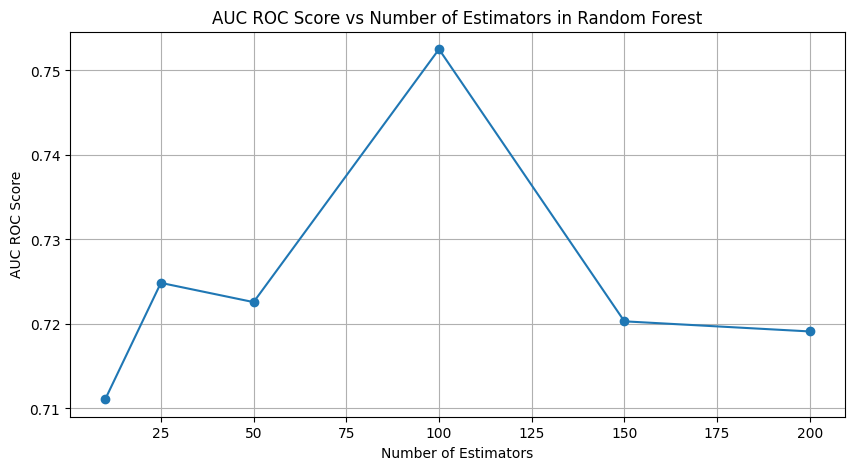

In [77]:
n_estimators = [10, 25, 50, 100, 150, 200]
auc_roc = []

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=15,
                                min_samples_leaf=1, random_state=13)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    auc_roc.append(roc_auc_score(y_test, y_pred))


plt.figure(figsize=(10, 5))
plt.plot(n_estimators, auc_roc, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('AUC ROC Score')
plt.title('AUC ROC Score vs Number of Estimators in Random Forest')
plt.grid(True)
plt.show()

Выводы, что 100 деревьев самый отпимальный вариант, который как раз показан выше

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<BarContainer object of 8 artists>

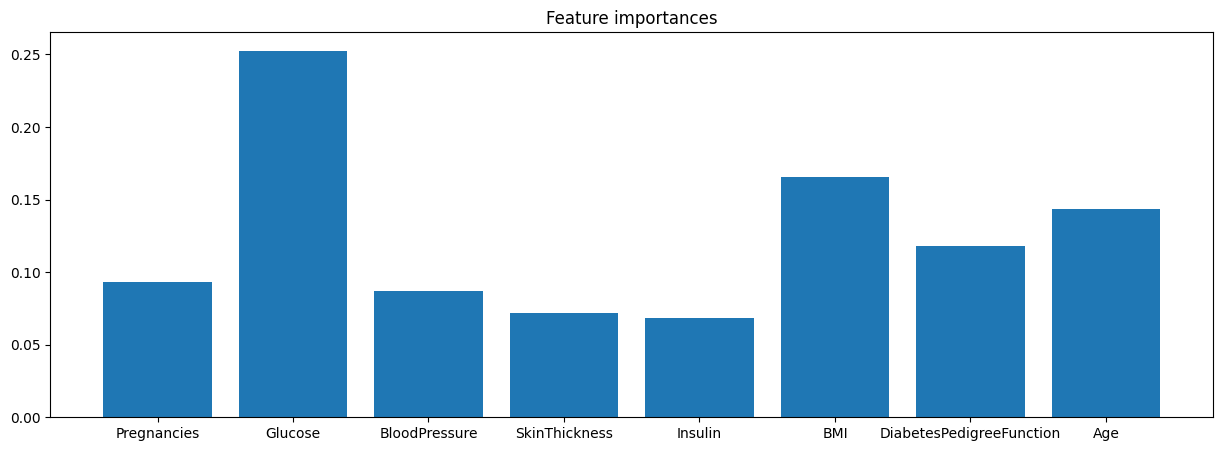

In [82]:
plt.figure(figsize=(15, 5))
plt.title("Feature importances")
plt.bar(X.columns, rf.feature_importances_)

Видим, что наиболее важный признак - Glucose, то есть видимо количество глюкозы), а следющие по важности - индекс массы тела. Что очень даже объяснимо